# Cifar-100 classification via Transfer learning.


  

## phase one:
### load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras

#clean log dir
!rm -rf logs/

## phase two:
### load data

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

#y_train= keras.utils.to_categorical(y_train, num_classes=10)    #make labels ONE-HOT
#y_test= keras.utils.to_categorical(y_test, num_classes=10)    #make labels ONE-HOT

#make sure about shape of data
assert x_train.shape == (50000, 32, 32, 3)
assert y_train.shape == (50000,1)

assert x_test.shape == (10000, 32, 32, 3)
assert y_test.shape == (10000, 1 )

#create val and test set
x_val = x_test[:8000]
x_test = x_test[8000:]
y_val = y_test[:8000]
y_test = y_test[8000:]

#make sure about shape of val and test
assert x_val.shape == (8000, 32, 32, 3)
assert y_val.shape == (8000, 1 )

assert x_test.shape == (2000, 32, 32, 3)
assert y_test.shape == (2000, 1 )

#map labes to names



169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Text(0.5, 1.0, 'label is [3]')

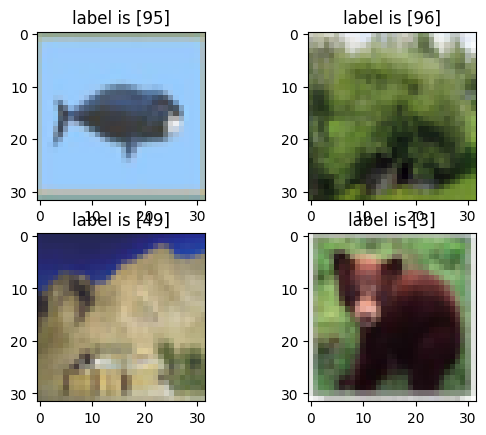

In [4]:
#visualize some random pics
rand = np.random.randint(low=0,high=50000, size=4)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[rand[0]])
axarr[0,0].set_title(f'label is {y_train[rand[0]]}')
axarr[0,1].imshow(x_train[rand[1]])
axarr[0,1].set_title(f'label is {y_train[rand[1]]}')

axarr[1,0].imshow(x_train[rand[2]])
axarr[1,0].set_title(f'label is {y_train[rand[2]]}')

axarr[1,1].imshow(x_train[rand[3]])
axarr[1,1].set_title(f'label is {y_train[rand[3]]}')

## phase Three:
### create model.
our model will contain of 3 models:

    1. a data augment model: to generate new pics and resize-rescale.
    2. a pre-trained model: in this case we use `EfficientNetV2S`.
    3. a dense and classifire: with Dense 512 and final classifire.


In [6]:
# augmnt model
augment_model = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomContrast(0.15),
    keras.layers.Resizing(100,100),
    keras.layers.Rescaling(1./255),
])

# pre-Trained model
xcept = keras.applications.Xception(include_top=False,
                                            weights='imagenet',
                                            input_shape=(100,100,3),
                                           )
# setting train ableing OFF
xcept.trainable = False

# 10 class classifire
classifire = keras.Sequential([
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=512,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=256,activation='relu'),
    keras.layers.Dense(units=100, activation='softmax')
])
# model in functial style
inputs = keras.Input(shape=(32,32,3))
x = augment_model(inputs)
x = xcept(x, training = False)
outputs = classifire(x)

model = keras.Model(inputs, outputs)

model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 3, 3, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 100)                 │       1,206,116 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,067,596 (84.18 MB)

 Trainable params: 1,206,116 (4.60 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

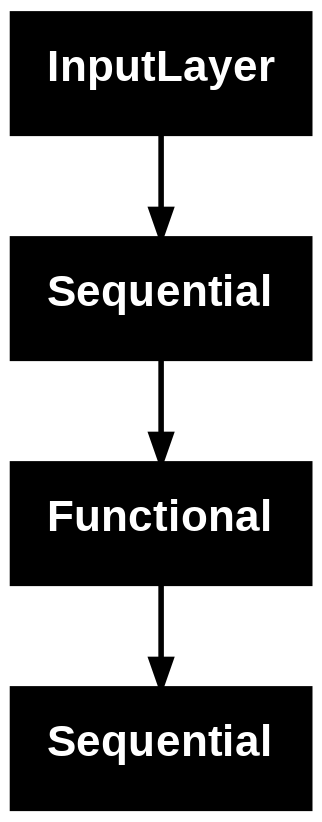

In [7]:
keras.utils.plot_model(model=model)

## phase Four:
### compile and train *Freezed* model

In [8]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy'
              ,metrics=['acc'],)

In [9]:
#custom call  back for +90 percent acc
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        '''
        Halts the training when the accuravy rise  above 90%

        Args:
            epoch (integer) - index of epoch (required but unused in the function definition below)
            logs (dict) - metric results from the training epoch
        '''

        # Check the loss
        if logs['val_acc'] > 80:

            # Stop if threshold is met
            print("\nLoss is lower than 0.4 so cancelling training!")
            self.model.stop_training = True
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [10]:
epoch = 25
hist = model.fit(x=x_train,y=y_train,batch_size=128,validation_data=(x_val,y_val),
          epochs=epoch,
                 callbacks=[myCallback(),
                        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5),
                        tensorboard_callback,
])
#20 + 200

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 145ms/step - acc: 0.1274 - loss: 3.9067 - val_acc: 0.3580 - val_loss: 2.5642 - learning_rate: 0.0010
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 77s 146ms/step - acc: 0.2553 - loss: 3.0565 - val_acc: 0.3855 - val_loss: 2.3995 - learning_rate: 0.0010
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - acc: 0.2755 - loss: 2.9269 - val_acc: 0.3969 - val_loss: 2.3290 - learning_rate: 0.0010
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 138ms/step - acc: 0.2880 - loss: 2.8524 - val_acc: 0.4099 - val_loss: 2.2844 - learning_rate: 0.0010
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - acc: 0.2897 - loss: 2.8313 - val_acc: 0.4185 - val_loss: 2.2217 - learning_rate: 0.0010
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 57s 146ms/step - acc: 0.3036 - loss: 2.7733 - val_acc: 0.4201 - val_loss: 2.2031 - learning_rate: 0.0010
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - acc: 0.3083 - loss: 2.7470 - val_acc: 0.4266 - val_loss: 2.1928 - learnin

In [11]:
#save model befor defreeze
model.save('cifar10-tl-befor-defreeze.keras')

## phase Five:
### Train End-to-End
final model will be ready soon!

In [ ]:
#defreeze model and retain
xcept.trainable = True
model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['acc'],)

In [ ]:
# End to End train
## NOTE: TRAIN FEW EPOCH 1~5
epoch = 3
model.fit(x=x_train,y=y_train,batch_size=128,validation_data=(x_val,y_val),
          epochs=epoch)

## FINAL MODEL

In [ ]:
model.save('cifar100-TL-fine-tuned.keras')

In [ ]:
model.evaluate(x=x_test,y=y_test)